## **IMPORTS**

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import module.feature_selection as feature_selection
import module.feature_engineering as feature_engineering
import module.visualization as visualization
import module.classification_model as classification_model

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix

In [2]:
%%capture
%run data_preprocessing.ipynb

## **K-NEAREST NEIGHBORS (KNN)**

### **Feature Pre-processing**

Poiché **KNN** è un modello di classificazione che lavora sulle **distanze**, è necessario effettuare un'operazione di **Feature Pre-processing** che uniformi la misura di tutte le Features in modo da non incorrere nella **distorsione dei risultati**.

Infatti:
- Se le Features hanno **scale diverse**, quelle con valori numerici **più grandi** avranno un **impatto sproporzionato** nel calcolo della distanza
- Una **mancata standardizzazione** può portare il modello a identificare i vicini più "prossimi" basandosi quasi esclusivamente sulle Features a **scala più ampia**, introducendo un **bias** che **riduce la capacità cogliere le relazioni reali tra i dati**.

Con **standard_scaler()**, procediamo a effettuare l'operazione di **Feature Pre-processing** attraverso la tecnica della **Standardizzazione**, che ridimensiona tutte le Features in un intervallo comparabile, **rendendole ugualmente importanti nel calcolo della distanza**.

In particolare, **StandardScaler()** trasforma i valori delle Features in una distribuzione con **media 0** e **deviazione standard 1**.

In [3]:
knn_X_train, knn_X_test = feature_engineering.standard_scaler(X_train_smote, X_test)

Con **feature_numerical_distribution_post_normalization_boxplot()**, visualizziamo tramite boxplot un confronto della distribuzione numerica delle Features **prima e dopo l'applicazione di StandardScaler**.

In [4]:
# Concateno le Features di Train e di Test per la visualizzazione grafica
knn_X = pd.concat(
    [knn_X_train, knn_X_test], 
    axis=0, 
    ignore_index=True
    )

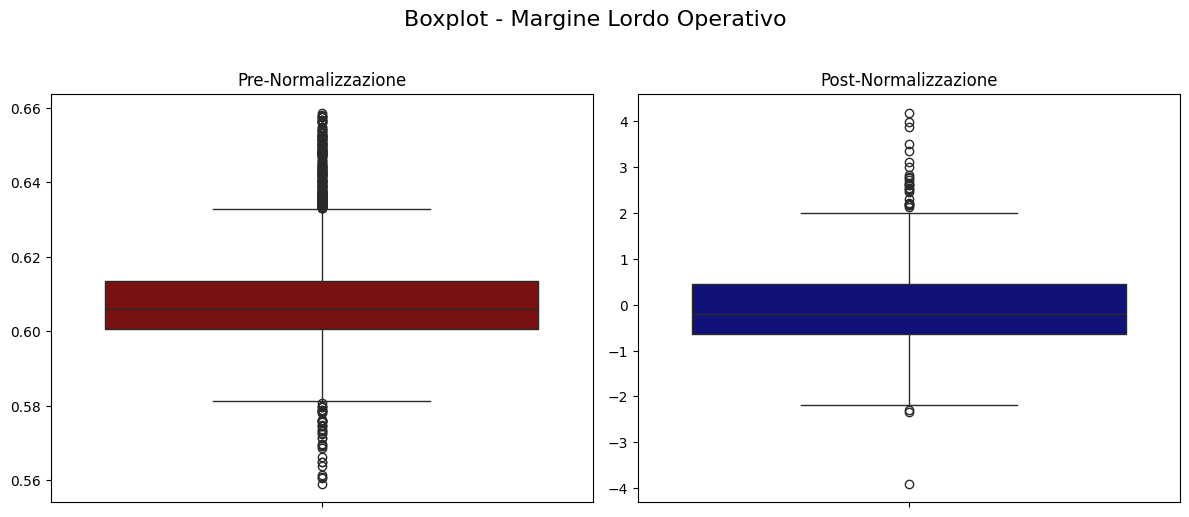

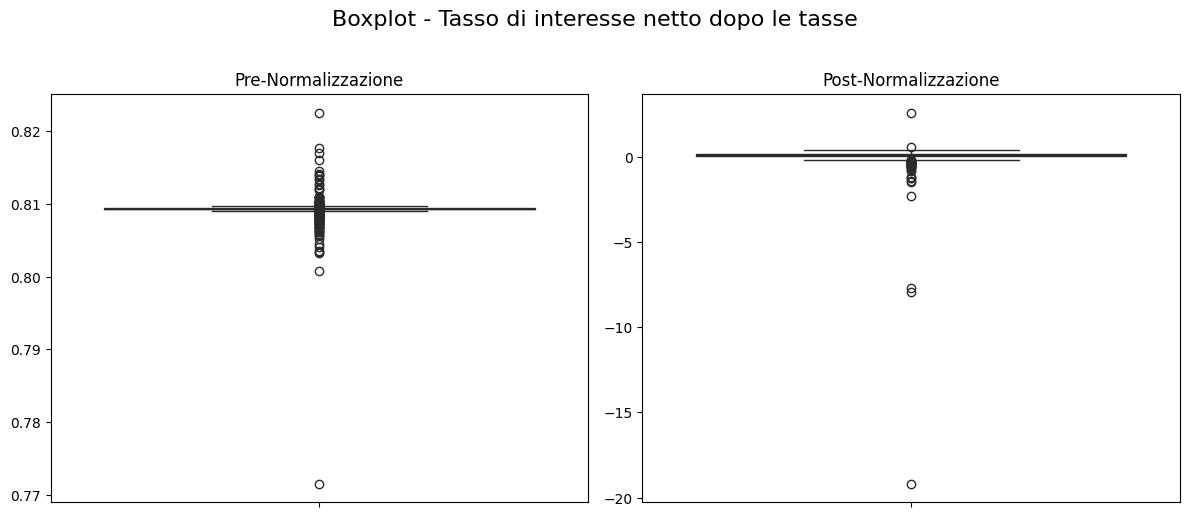

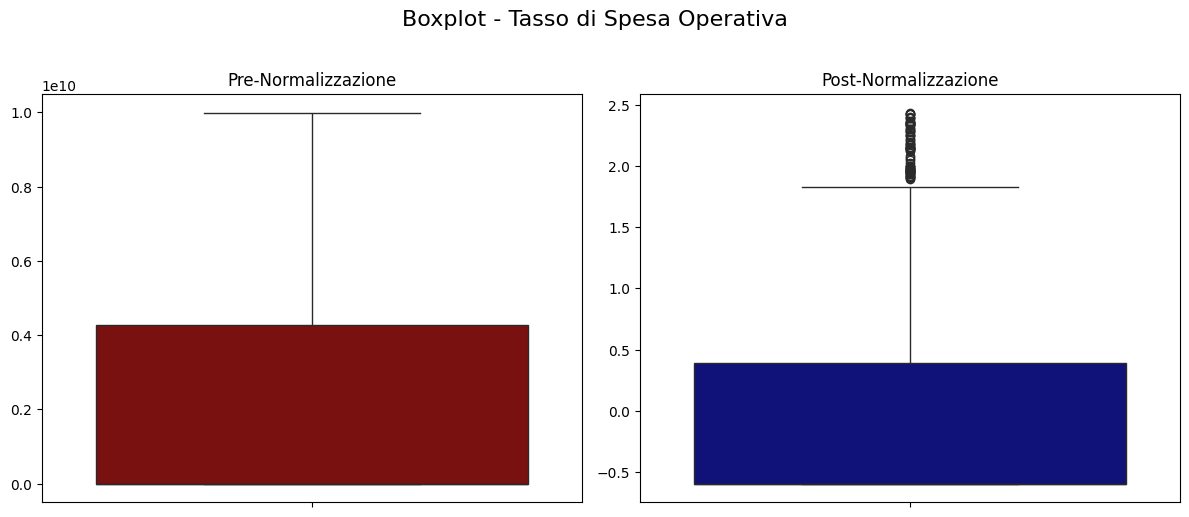

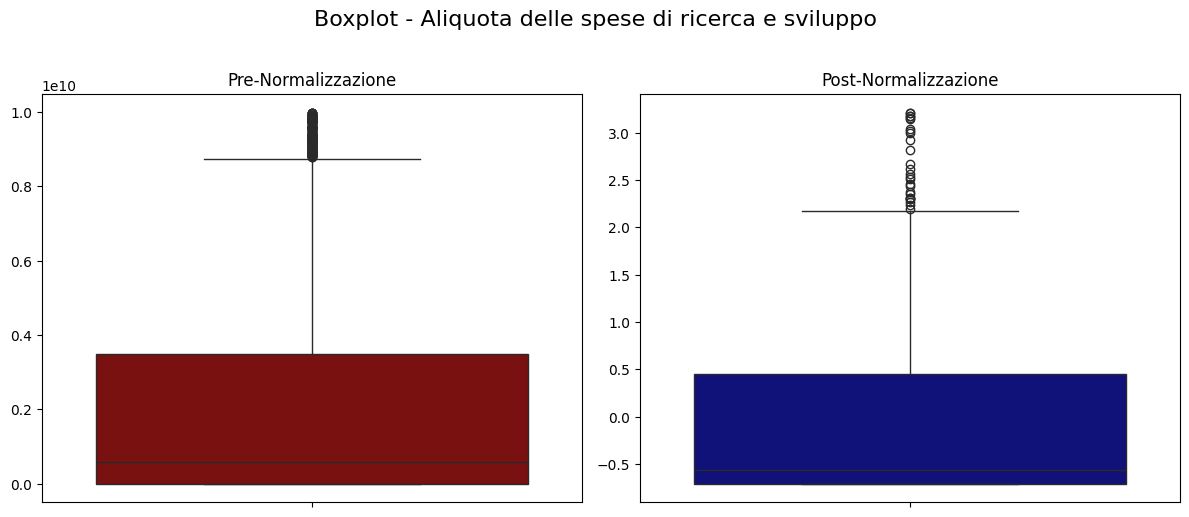

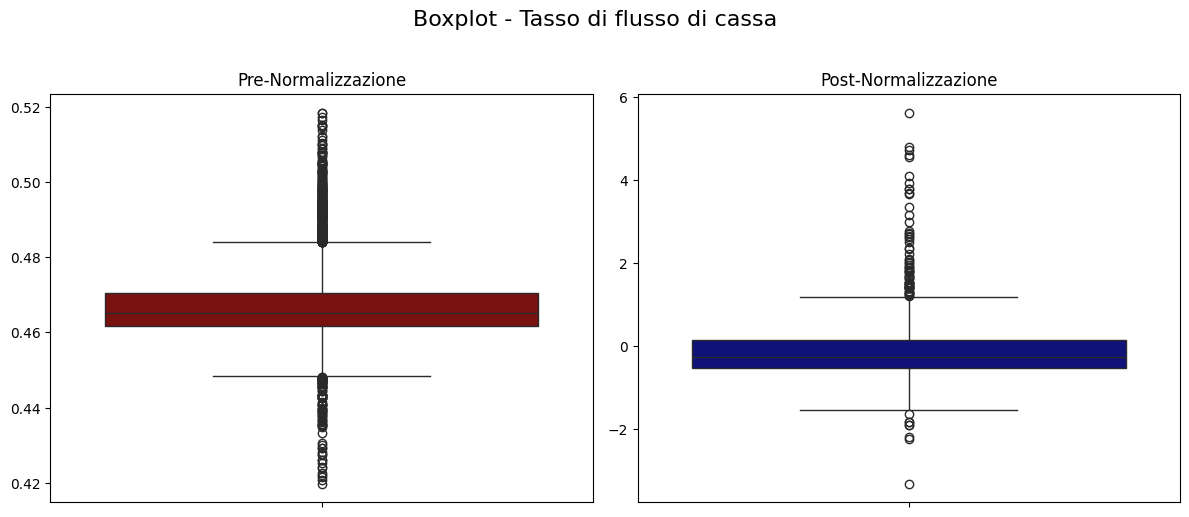

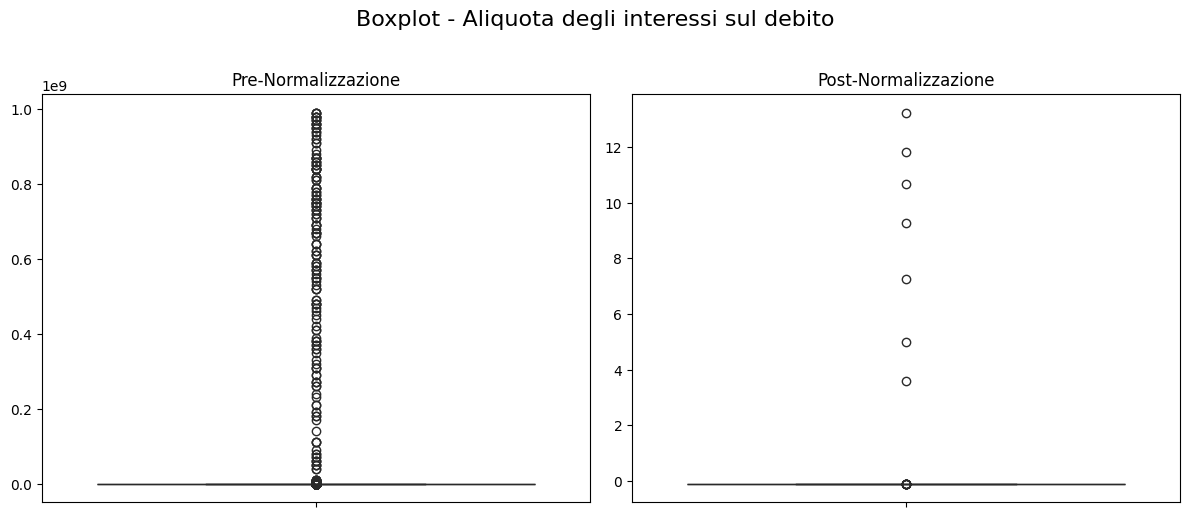

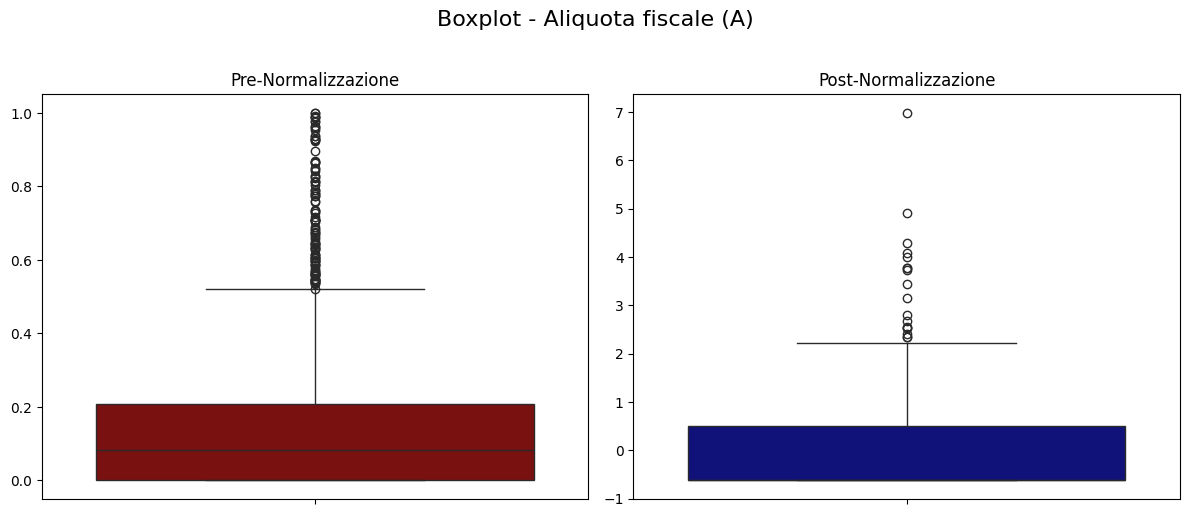

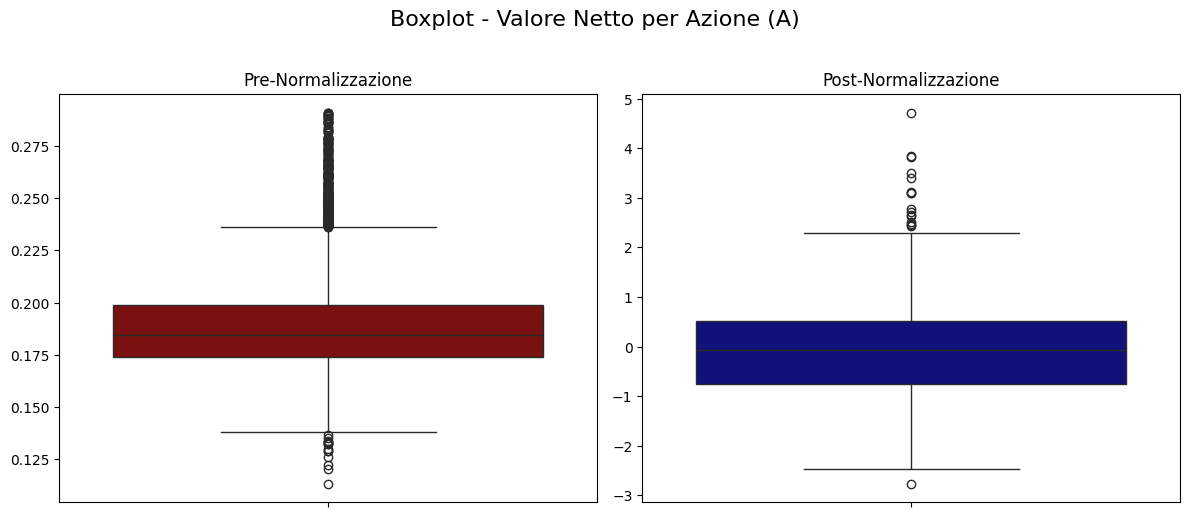

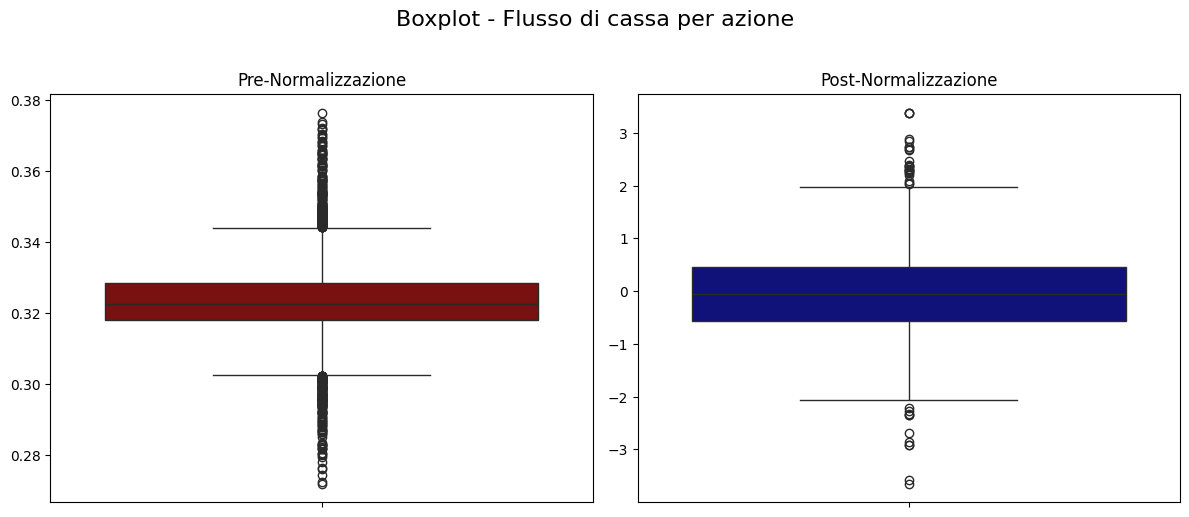

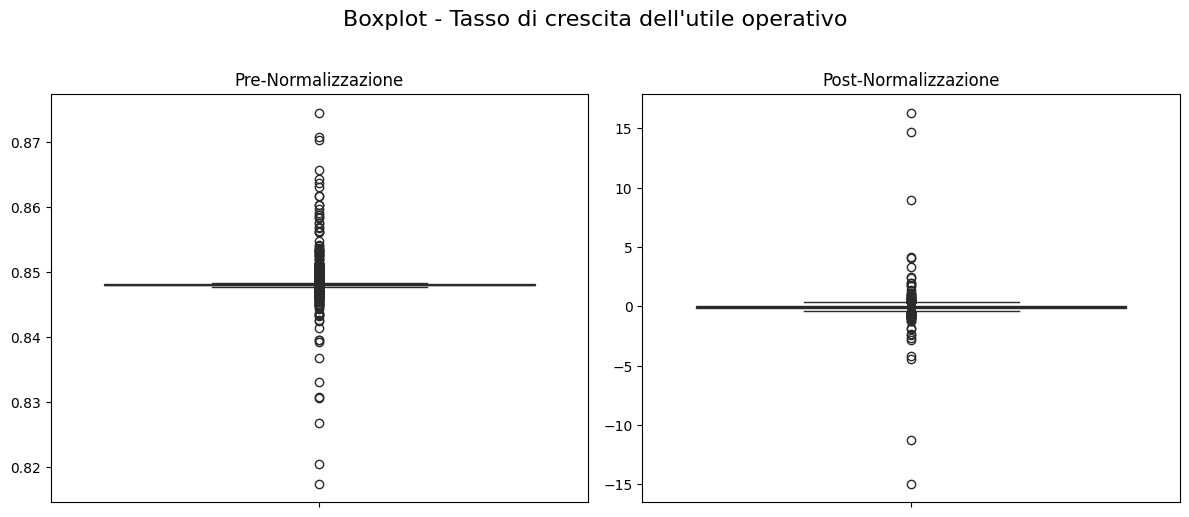

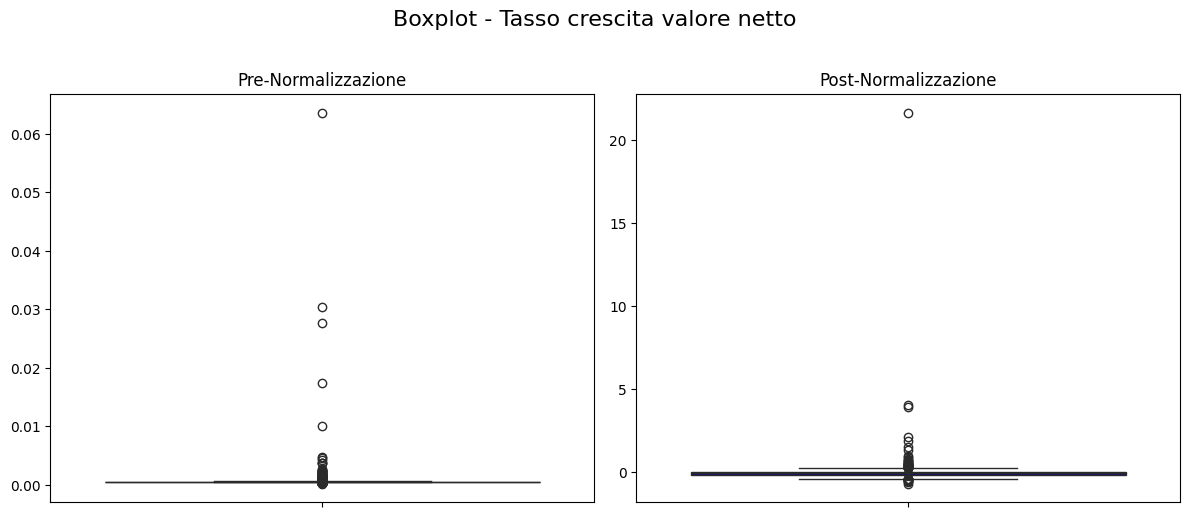

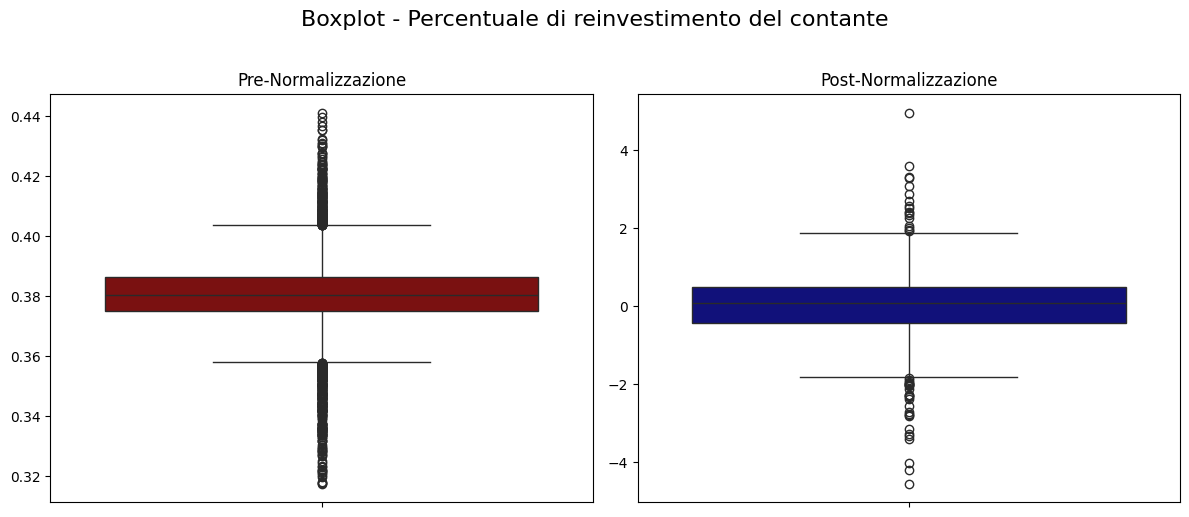

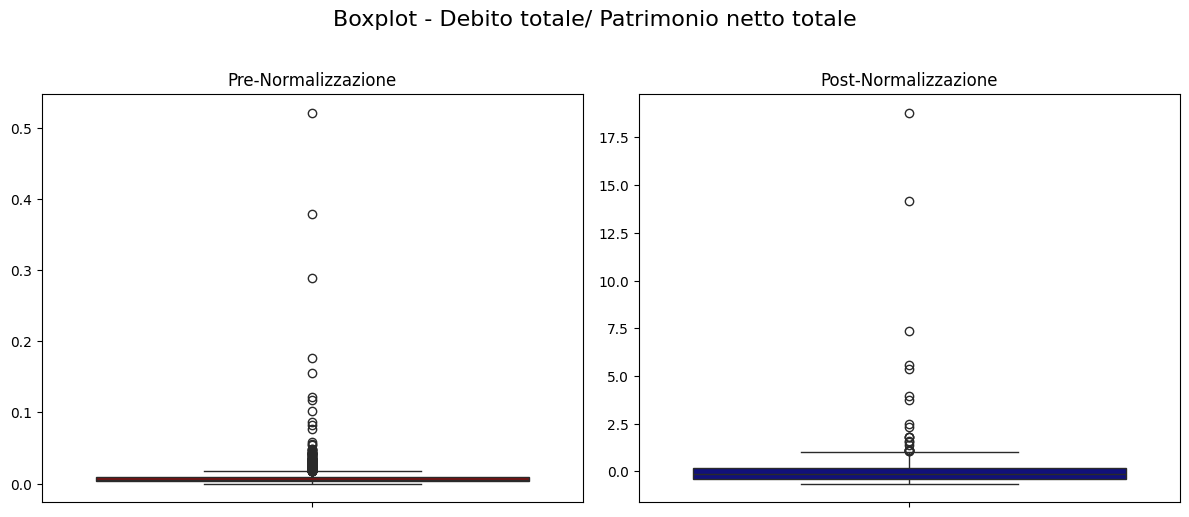

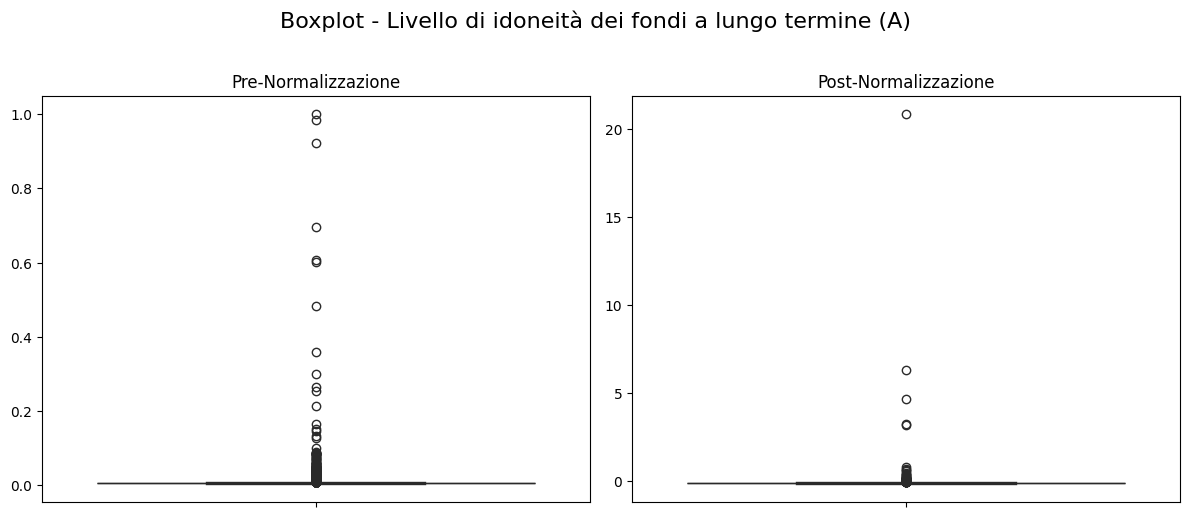

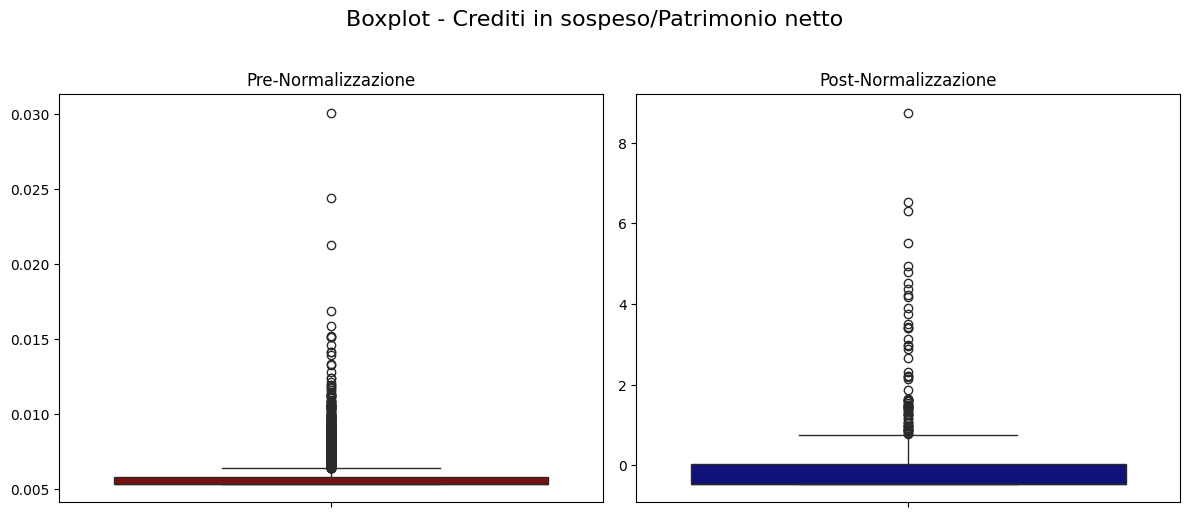

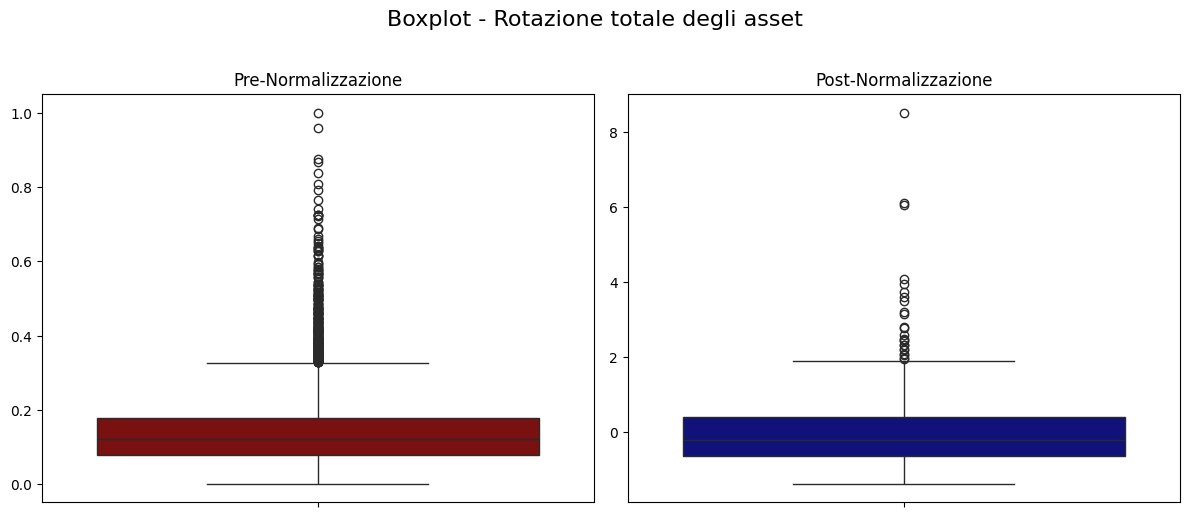

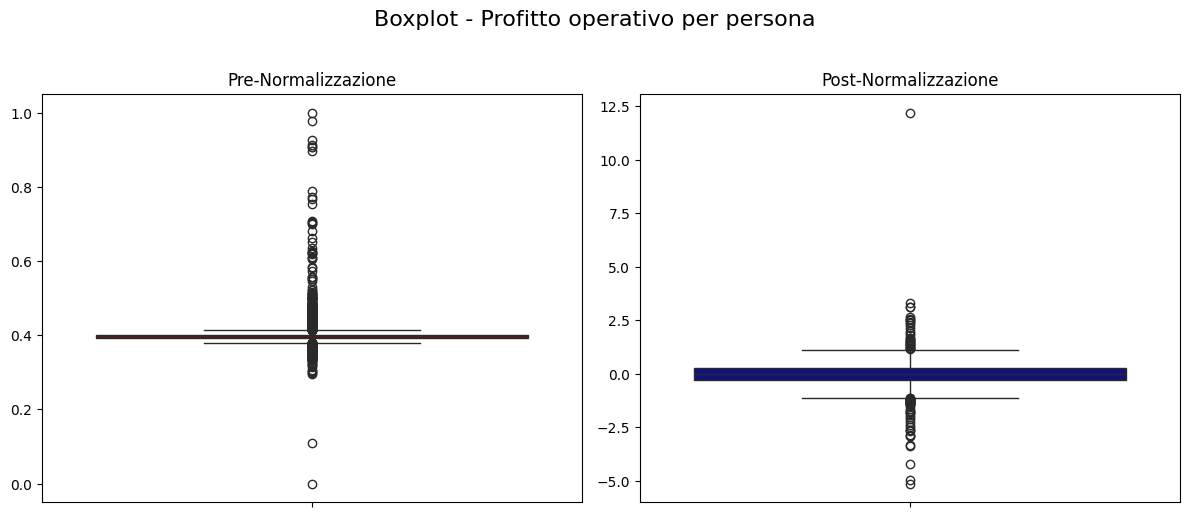

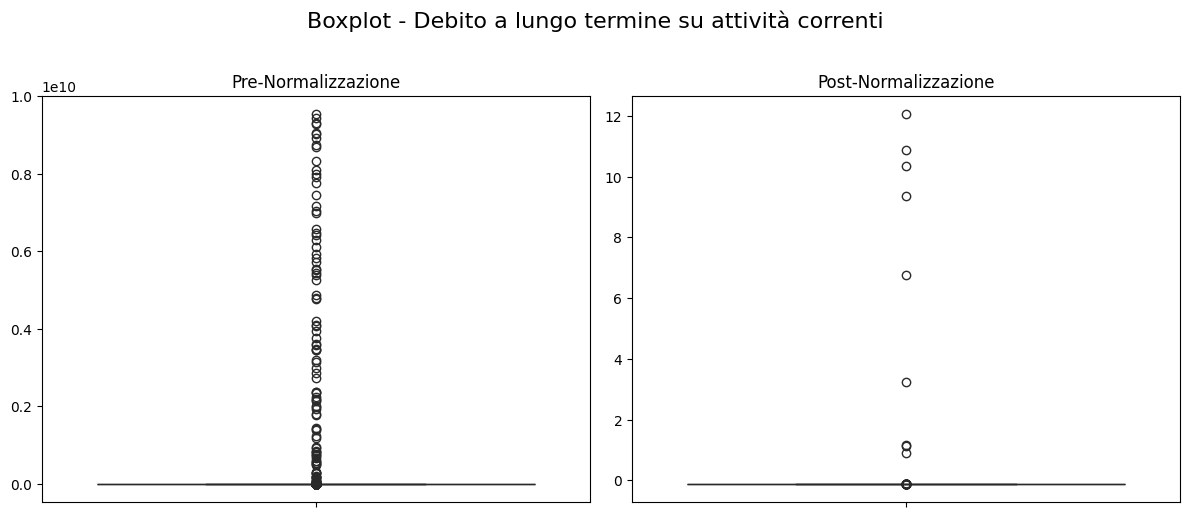

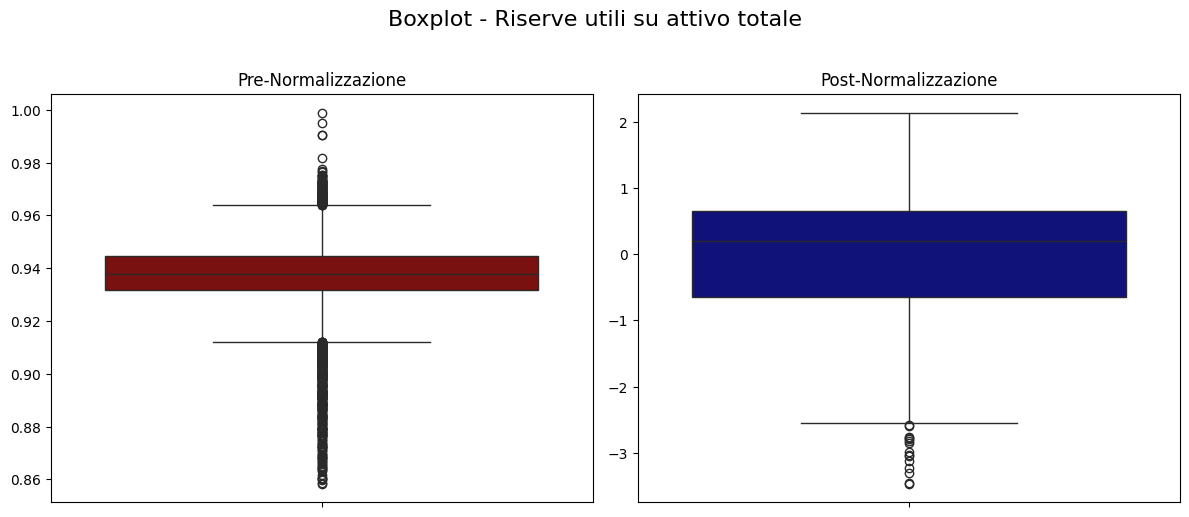

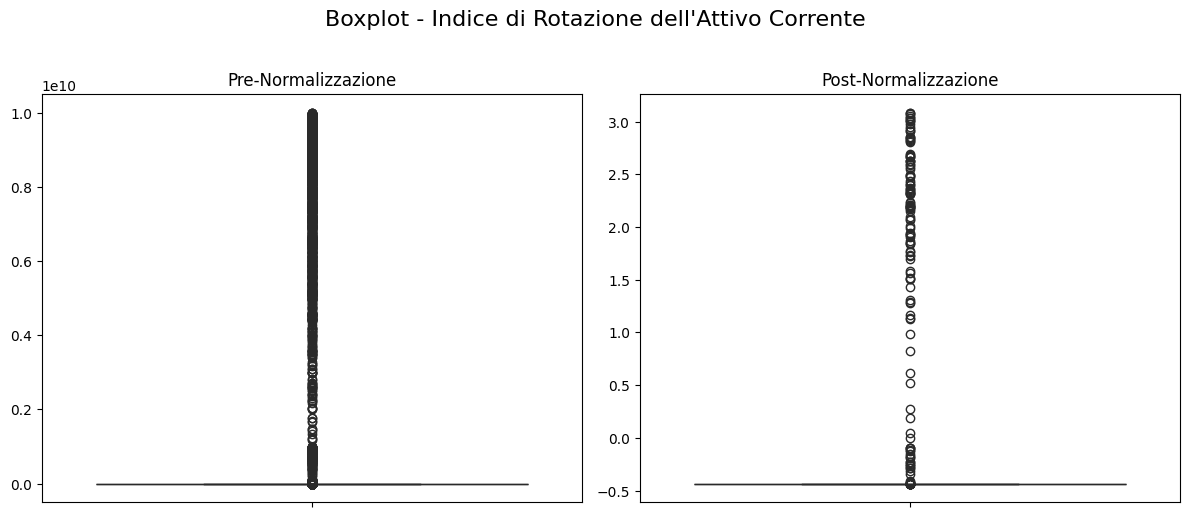

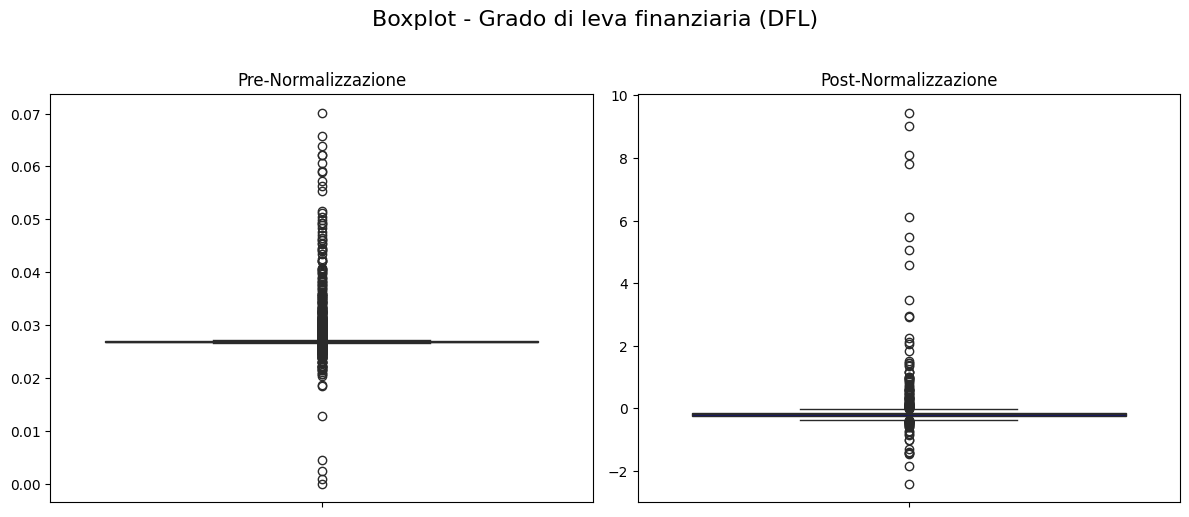

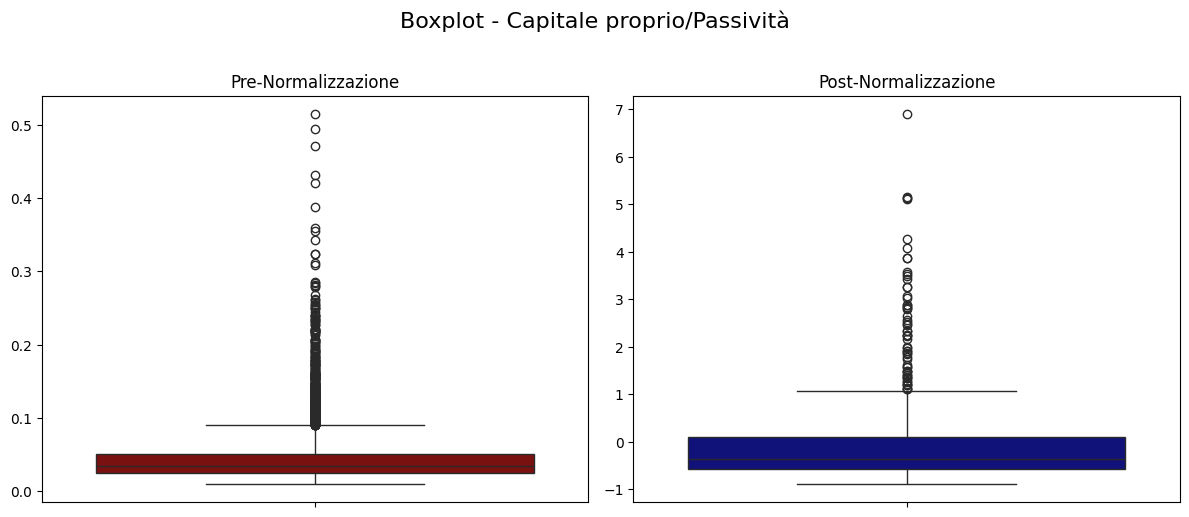

In [5]:
visualization.feature_numerical_distribution_post_normalization_boxplot(X_uncorr_clean, knn_X, knn_X.columns)

### **Feature Selection**

Come nel caso della Regressione Logistica e per garantire anche la **comparabilità tra i risultati dei modelli**, effettuiamo un'operazione di **Feature Selection**, con l'obiettivo di migliorare le performance di KNN.

Essendo RFE un algoritmo che lavora sull'importanza delle Features e KNN un modello che non ha un parametro che descrive questa caratteristica, effettueremo l'operazione di Feature Selection **solo con SKB**.

In [6]:
# Inizializzo il modello di KNN
knn = KNeighborsClassifier()

Con **calculate_accuracy()**, calcoliamo l'accuracy del modello per ogni k-esima Features

In [7]:
# Calcolo l'accuracy del modello per ogni k-esima Features con SKB
knn_skb_accuracies = feature_selection.calculate_accuracy('skb', knn, knn_X_train, y_train_smote)

100%|██████████| 22/22 [00:04<00:00,  4.62it/s]

Riserve utili su attivo totale: 0.8074383164005805
Valore Netto per Azione (A): 0.7960812772133526
Capitale proprio/Passività: 0.8321117561683599
Tasso di flusso di cassa: 0.849310595065312
Margine Lordo Operativo: 0.8341074020319302
Flusso di cassa per azione: 0.8301161103047896
Profitto operativo per persona: 0.8358853410740202
Aliquota fiscale (A): 0.8302975326560234
Debito totale/ Patrimonio netto totale: 0.8302612481857764
Rotazione totale degli asset: 0.845609579100145
Percentuale di reinvestimento del contante: 0.8399854862119012
Tasso di interesse netto dopo le tasse: 0.8418722786647315
Crediti in sospeso/Patrimonio netto: 0.8455370101596517
Tasso crescita valore netto: 0.8513062409288825
Tasso di crescita dell'utile operativo: 0.845609579100145
Aliquota degli interessi sul debito: 0.8474963715529753
Debito a lungo termine su attività correnti: 0.8531930333817126
Livello di idoneità dei fondi a lungo termine (A): 0.8531930333817126
Tasso di Spesa Operativa: 0.8513425253991291
A

Con **k_accuracy_lineplot2()**, visualizzaziamo con lineplot l'accuracy di KNN con SKB, mettendo in evidenza il **k ottimale**, che in questo caso è **4** con un accuracy di **0.8493**.

Come nel caso della Regressione Logistica, il **k ottimale** viene scelto ad occhio, in modo da garantire un **corretto trade-off tra complessità e generalizzazione**. Osservando il grafico sottostante, il k ottimale corrisponde al **primo massimo relativo**, ovvero il punto dopo cui la linea ha il **primo andamento verso il basso**.

Non andiamo a scegliere il **massimo assoluto**, ovvero il k che garantisce l'accuracy più alta, per evitare **problemi di overfitting**.

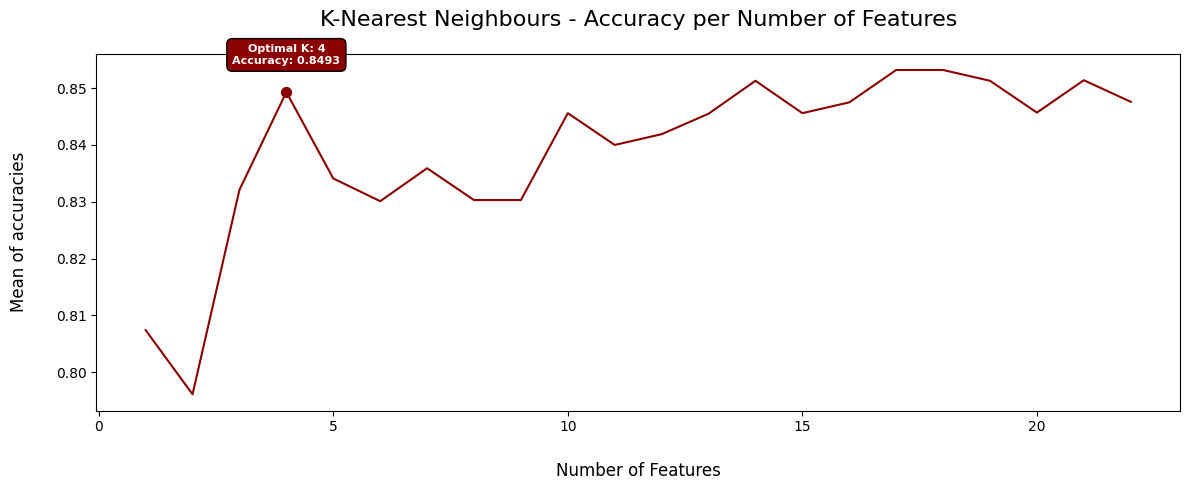

In [8]:
visualization.k_accuracy_lineplot2('K-Nearest Neighbours' ,knn_skb_accuracies, 4)

Con **feature_selection()**, salviamo quali sono le Features più significative per SKB con KNN.

In [9]:
knn_skb_selected_features = feature_selection.feature_selection('skb', knn, knn_X_train, y_train_smote, 4)

Con **tune_knn_hyperparameters()**, ottimizziamo gli iper-parametri di KNN, con le Features Selezionate da **SKB**, utilizzando la tecnica di **Grid Search** combinata con **K-Fold Cross-validation**, al fine di massimizzare ulteriormente le performance del modello, migliorando la generalizzazione sui dati di test.

In particolare, con **GridSearchCV** effettuiamo due operazioni:
1. Definiamo la **griglia di iperparametri** di cui vogliamo ricercare la **combinazione ottimale**. Nel caso di KNN, vogliamo ottenere la combinazione ottimale dei seguenti iper-parametri: **numero di vicini**  e **metrica di distanza**. 
2. Tramite **K-Fold Cross-validation**, calcoliamo l'**accuracy** di KNN, con l'impostazione ottimale degli iper-parametri ottenuta nel primo punto, su **più set di dati**, in modo da ottenere una **valutazione più affidabile e robusta** delle performance del modello. 

L'output finale restituisce:
- Il numero ottimale di vicini (**Best K**), che nel nostro caso è **8**. Il **k ottimale** è stato scelto in un **range tra 1 e 23 vicini** (valore calcolato come **radice quadrata del numero di osservazioni dei dati di train**)
- La metrica di distanza ottimale (**Best Metric**), che nel nostro caso è quella di **Manhattan**. Infatti, nei nostri dati sono ancora presenti **outliers**, che la precedente operazione di data pre-processing non è riuscita a rimuovere del tutto, e la **distanza di Manhattan**, rispetto a quella euclidea, è **più robusta** e **meno sensibile a dati estremi**
- La miglior accuracy media ottenuta durante la K-Fold Cross-validation (**Internal Accuracy**), che nel nostro caso è pari a **0.8397**

In [10]:
knn_cv = classification_model.tune_knn_hyperparameters(knn, knn_skb_selected_features, y_train_smote)

Best K: 8
Best Metric: manhattan
Best Accuracy: 0.8397985347985347


Con **model_accuracy()**, calcoliamo l'accuracy di KNN, con le **Features selezionate da RFE** e il **numero di vicini selezionati da GridSearchCV**, sui dati di test.

L'accuracy che otteniamo è modesto (**0.71**). Per giungere alle conclusioni, procediamo a calcolare **matrice di confusione** e le **relative metriche**, insieme all'**AUC-ROC** e l'**Indice di Gini**

In [11]:
knn_y_pred, knn_y_proba, knn_test_accuracy = classification_model.model_accuracy(knn_cv, knn_skb_selected_features, knn_X_test[knn_skb_selected_features.columns], y_train_smote,  y_test)

Test Accuracy: 0.7162162162162162


Con **confusion_matrix_heatmap()**, visualizziamo la **matrice di confusione** di KNN.

I risultati sono i seguenti:
- **True Negatives** (**0**): il modello ha indovinato **28** compagnie che non vanno in bancarotta
- **False Positives** (**1**): il modello ha classificato **9** compagnie non in bancarotta come se andassero in bancarotta
- **False Negatives** (**0**): il modello ha classificato **12** compagnie in bancarotta come se non andassero in bancarotta
- **True Positives** (**1**): il modello ha indovinato **25** compagnie che vanno in bancarotta


In [12]:
# Calcolo la matrice di confusione sul Test Set 
knn_conf_matrix = confusion_matrix(y_test, knn_y_pred)

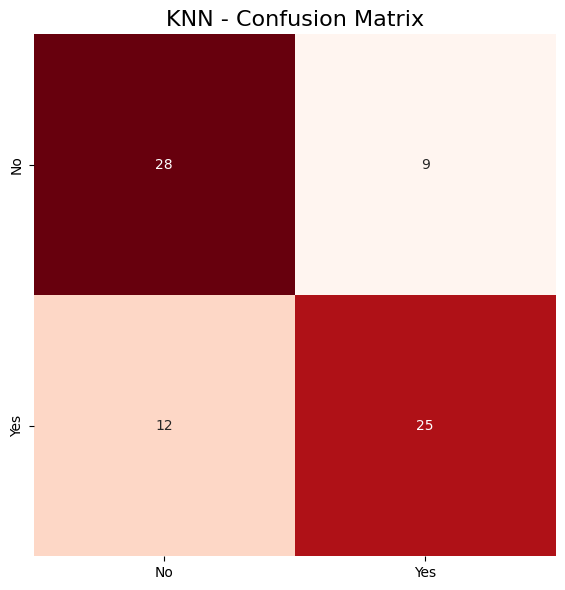

In [13]:
visualization.confusion_matrix_heatmap('KNN', knn_conf_matrix)

Con **conf_matrix_coefficients_analysis()**, analizziamo i **coefficienti** della matrice di confusione di KNN:
- **Precisione**: tra le compagnie classificate come in bancarotta, il modello indovina correttamente il **73%** dei casi 
- **Recall**: tra le compagnie effettivamente in bancarotta, il modello classifica correttamente il **67%** di esse come tali.
- **F1-score**: il modello ha un buon equilibrio tra Precision e Recall (**0.70**), indicando una performance complessiva solida nel distinguere tra compagnie in bancarotta e non
- **Specificità**: il modello riesce a indovinare **il 75%** delle compagnie che non vanno in bancarotta

Ricordando che l'obiettivo dell'analisi è quello di **prevedere le compagnie che vanno in bancarotta**, i risultait che abbiamo ottenuto non sono molto buoni.


In [14]:
# Calcolo i coefficienti della Matrice di Confusione per KNN
knn_precision, knn_recall, knn_f1, knn_tn, knn_fp, knn_fn, knn_tp, knn_specificity = classification_model.conf_matrix_coefficients_analysis(y_test, knn_y_pred, knn_conf_matrix)

Precisione: 0.7352941176470589
Recall: 0.6756756756756757
F1-score: 0.704225352112676
Specificità: 0.7567567567567568


Con **conf_matrix_coefficients_to_df()**, creiamo un **dataframe per le metriche della matrice di confusione** di KNN, che ci torna utile nel passaggio successivo in cui andiamo a costruire una **visualizzazione grafica**.

In [15]:
knn_conf_matrix_coefficients_df = classification_model.conf_matrix_coefficients_to_df(
    knn_precision,
    knn_recall,
    knn_f1,
    knn_specificity
)

Con **conf_matrix_coefficients_barplot2()**, visualizziamo tramite barplot le metriche della matrice di confusione di KNN

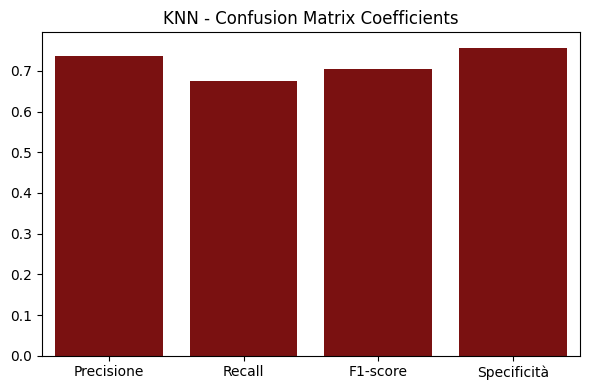

In [16]:
visualization.conf_matrix_coefficients_barplot2('KNN', knn_conf_matrix_coefficients_df)

Con **model_auc_roc_gini()**, calcoliamo l'**AUC-ROC** e l'**Indice di Gini** per KNN.

Dal risultato ottenuto, possiamo dire che KNN ha una **buona capacità di distinguere tra compagnie in bancarotta e non**.

In [17]:
knn_auc, knn_gini = classification_model.model_auc_roc_gini('KNN', knn_y_pred, y_test)

KNN - AUC-ROC: 0.7162162162162162
KNN - Indice di Gini: 0.43243243243243246


Con **roc_curve_plot()**, visualizziamo graficamente la **curva ROC** di KNN.

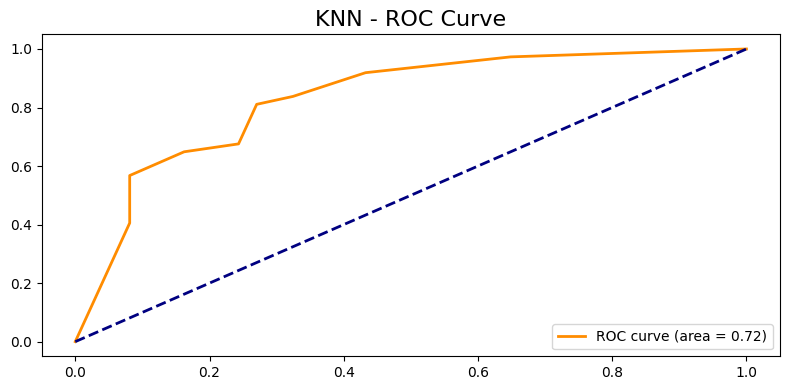

In [18]:
visualization.roc_curve_plot2('KNN', y_test, knn_y_proba, knn_auc)